# Compare Models

In [1]:
import sys
sys.path.append("../")

from haxml.utils import (
    get_stadiums,
    get_matches_metadata,
    train_test_split_matches_even_count,
    get_opposing_goalpost,
    stadium_distance,
    angle_from_goal,
    is_scored_goal,
    # my features
    get_positions_at_time,
    defender_feature, # closest defender, defenders within dist
    defender_box, # count defender within goal and shot in rect
    defender_cone, # count defenders between shot and goal in cone
    speed_ball
)
from haxml.evaluation import (
    summarize_split,
    style_columns,
    make_df,
    score_model,
    run_models,
    blank_plot,
    plot_errors_by_kicks,
    plot_errors_by_goals,
    plot_xg_histogram
)
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Load Data and Make Train/Test Split

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")
train, test = train_test_split_matches_even_count(metadata)

In [3]:
print("Train Data:")
summarize_split(train)
print()
print("Test Data:")
summarize_split(test)

Train Data:
Matches: 851
Goals: 2,390
Kicks: 70,480
E(XG): 0.034

Test Data:
Matches: 850
Goals: 2,385
Kicks: 69,061
E(XG): 0.035


## Feature Engineering

Add all your new features to the `generate_rows_compare()` method.

## Todo:
Get the speed of the ball and area of the box/triangle

In [9]:
def is_fast_break(kick):
    '''
    Takes in a kick and where it ends up 
    '''
    if ball
    travel_dist = ((kick['fromX'] - kick['toX'])**2 + (kick['fromY'] - kick['toY'])**2)**(1/2)
    if travel_dist > 300 and kick['type'] == "steal":
        return True
    return False

In [10]:
def generate_rows_compare(match, stadium):
    """
    Generates target and features for each kick in the match.
    Produces many features for model comparison.
    Args:
        match: Inflated match data (dict).
        stadium: Stadium data (dict).
    Returns:
        Generator of dicts with values for each kick in the given match.
        Includes prediction target "ag" (actual goals) which is 1 for a scored
        goal (goal or error) and 0 otherwise, "index" which is the index of the
        kick in the match kick list, and all the other features needed for
        prediction and explanation.
    """
    for i, kick in enumerate(match["kicks"]):
        gp = get_opposing_goalpost(stadium, kick["fromTeam"])
        x = kick["fromX"]
        y = kick["fromY"]
        gx = gp["mid"]["x"]
        gy = gp["mid"]["y"]
        dist = stadium_distance(x, y, gx, gy)
        angle = angle_from_goal(x, y, gx, gy)
        defender_dist,closest_defender = defender_feature(match,kick,100)
        defenders_within_box,in_box = defender_box(match,stadium,kick)
        defenders_within_shot,in_shot = defender_cone(match,stadium,kick,1)
        ball_speed=speed_ball(match,kick,1)
        fast_break=is_fast_break(kick)
        row = {
            "ag": 1 if is_scored_goal(kick) else 0,
            "index": i,
            "time": kick["time"],
            "x": x,
            "y": y,
            "goal_x": gx,
            "goal_y": gy,
            "goal_distance": dist,
            "goal_angle": angle,
            "team": kick["fromTeam"],
            "stadium": match["stadium"],
            "defender_dist": defender_dist, # numerical , numbers within a range
            "closest_defender": closest_defender, # numerical, distance of the closest 
            "defenders_within_box": defenders_within_box, # numerical, number of player(defenders) within goal and kick(ball)
            "in_box": in_box, # Boolean, Is there defenders in this boxb bteween goal and kick
            "defenders_within_shot": defenders_within_shot, # numerical, how many players(defenders) are in this cone
            "in_shot": in_shot, # Boolean, Is there defenders in this cone
            "ball_speed": ball_speed, # numerical, speeds ball within a given time range
            "fast_break": fast_break # Boolean, is there a fastbreak happening based on a hueristic
        }
        yield row

In [11]:
d_train = make_df(train, stadiums, generate_rows_compare, progress=True)
d_test = make_df(test, stadiums, generate_rows_compare, progress=True)

  0%|          | 0/851 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

## Train Models

Specific all the models and feature sets you want to use below.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
from itertools import chain, combinations

features = ["goal_distance",
            "goal_angle",
            "defender_dist",
            "closest_defender",
            "defenders_within_box",
            "in_box",
            "defenders_within_shot",
            "in_shot",
            "ball_speed"]
feature_sets = []


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(4,len(s)+1))

results = list(powerset(features))
for res in results:
    feat = list(res)
    feature_sets.append(feat)
#feature_sets

In [8]:
feature_sets = [
    ["goal_distance","goal_angle","defender_dist","closest_defender","defenders_within_box","in_box","in_shot","ball_speed"], # best model
    ["goal_distance","goal_angle","defender_dist","ball_speed"],
    ["goal_distance","goal_angle","defender_dist","closest_defender","in_box","ball_speed"]
    #["goal_distance", "goal_angle","defender_dist","closest_defender"],
    #["goal_distance", "goal_angle","defender_dist","defenders_within_box","ball_speed"],
    #["goal_distance","goal_angle","defender_dist","closest_defender","defenders_within_box","defenders_within_shot","ball_speed"],
    #["goal_distance","goal_angle","defender_dist","closest_defender","defenders_within_box","ball_speed"]
]

In [9]:
model_params = [
    (RandomForestClassifier, {"max_depth":15, "random_state":0}),
    (RandomForestClassifier, {"max_depth":12, "random_state":0}),
]

#Some of the models I tried
#(LogisticRegression, {"random_state": 0}),
#(DecisionTreeClassifier, {}),
#(DecisionTreeClassifier, {"max_depth": 3}),
#(DecisionTreeClassifier, {"max_depth": 5}),
#    (KNeighborsClassifier, {"n_neighbors": 5}),
#    (KNeighborsClassifier, {"n_neighbors": 10}),
#(GradientBoostingClassifier, {"n_estimators":100, "learning_rate":1.0,"max_depth":1, "random_state":0})

In [10]:
df_scored = run_models(d_train, d_test, score_model, "ag", feature_sets, model_params)

Model: RandomForestClassifier(max_depth=12, random_state=0): 100%|██████████| 6/6 [01:27<00:00, 14.61s/it]


## Rank Models By Score

Call `help()` on `score_model()` to find out what the scoring metrics mean.

In [11]:
help(score_model)

Help on function score_model in module haxml.evaluation:

score_model(d_test, target, features, clf, kwargs)
    Score a given model and return its metrics and metadata.
    Args:
        d_test: DataFrame of test data.
        target: Variable to predict (str).
        features: Columns of DataFrame to use as predictors (list of str).
        clf: Classifier (sklearn style).
        kwargs: Keyword args for classifier.
    Scores:
        accuracy: correct predictions / all records
        precision: true positives / predicted positives
        recall: true positives / actual positives
        roc_auc: area under the ROC curve (0.5 is as good as random)
        match_mae: mean absolute error between XG and AG per match
        match_rmse: root mean squared error between XG and AG per match
        xg_mean: mean of XG on dataset
        xg_std: standard deviation of XG on dataset
    Returns:
        Dictionary with fields for scoring metrics and model metadata.



In [12]:
score_color = "94, 156, 255"
style_config = {
    "accuracy": {"rgb": score_color, "low": 0, "high": 1},
    "precision": {"rgb": score_color, "low": 0, "high": 1},
    "recall": {"rgb": score_color, "low": 0, "high": 1},
    "roc_auc": {"rgb": score_color, "low": 0.5, "high": 1},
    "match_mae": {"rgb": score_color, "low": 3, "high": 0},
    "match_rmse": {"rgb": score_color, "low": 3, "high": 0},
    "xg_mean": {"rgb": score_color, "low": 0, "high": 0.07},
    "xg_std": {"rgb": score_color, "low": 0, "high": 0.5},
}

In [13]:
df_ranked = df_scored \
    .sort_values(by=["precision", "roc_auc"], ascending=[False, False]) \
    .reset_index()
df_ranked \
    [["clf", "features"] + list(style_config.keys())] \
    .style.apply(style_columns(style_config)) \
    .set_precision(3)

,clf,features,accuracy,precision,recall,roc_auc,match_mae,match_rmse,xg_mean,xg_std
0,"RandomForestClassifier(max_depth=12, random_state=0)","['goal_distance', 'goal_angle', 'defender_dist', 'closest_defender', 'defenders_within_box', 'in_box', 'in_shot', 'ball_speed']",0.969,0.749,0.153,0.575,1.229,1.556,0.034,0.087
1,"RandomForestClassifier(max_depth=12, random_state=0)","['goal_distance', 'goal_angle', 'defender_dist', 'closest_defender', 'in_box', 'ball_speed']",0.970,0.720,0.198,0.598,1.245,1.584,0.034,0.093
2,"RandomForestClassifier(max_depth=15, random_state=0)","['goal_distance', 'goal_angle', 'defender_dist', 'closest_defender', 'defenders_within_box', 'in_box', 'in_shot', 'ball_speed']",0.969,0.694,0.204,0.601,1.227,1.555,0.034,0.094
3,"RandomForestClassifier(max_depth=15, random_state=0)","['goal_distance', 'goal_angle', 'defender_dist', 'closest_defender', 'in_box', 'ball_speed']",0.970,0.664,0.242,0.619,1.242,1.588,0.034,0.099
4,"RandomForestClassifier(max_depth=12, random_state=0)","['goal_distance', 'goal_angle', 'defender_dist', 'ball_speed']",0.969,0.654,0.231,0.613,1.287,1.638,0.034,0.099
5,"RandomForestClassifier(max_depth=15, random_state=0)","['goal_distance', 'goal_angle', 'defender_dist', 'ball_speed']",0.969,0.621,0.253,0.623,1.294,1.647,0.034,0.102


## Visualize Model Results

Model IDs are the ranks (starting from 0) of the models. We can compare the top three models with these plots.

In [14]:
models = df_ranked.to_dict(orient="records")
model_ids = [0, 1, 2]
pal = sns.hls_palette(len(model_ids))

In [15]:
import joblib
clf = models[0]['clf']
joblib.dump(clf,"../models/random_forest_max_depth_12.pkl")
clf = models[2]['clf']
joblib.dump(clf,"../models/random_forest_max_depth_15.pkl")

['../models/random_forest_max_depth_15.pkl']

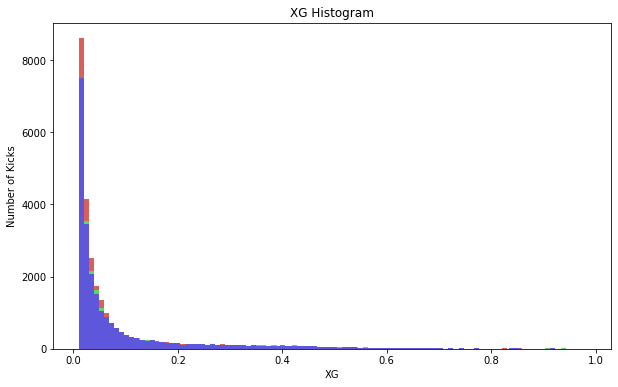

In [23]:
plot = blank_plot()
hist_kwargs = {"bins": 100}
for model_id, color in zip(model_ids, pal):
    hist_kwargs["color"] = color
    plot = plot_xg_histogram(models[model_id], d_test, plot, hist_kwargs, min_xg=1e-2)
plot[1].get_legend().remove()
plot[0]

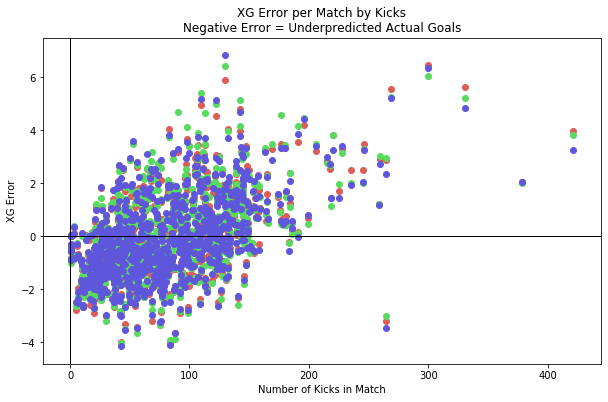

In [24]:
plot = blank_plot()
for model_id, color in zip(model_ids, pal):
    plot = plot_errors_by_kicks(models[model_id], d_test, plot, {"color": color})
plot[1].get_legend().remove()
plot[0]

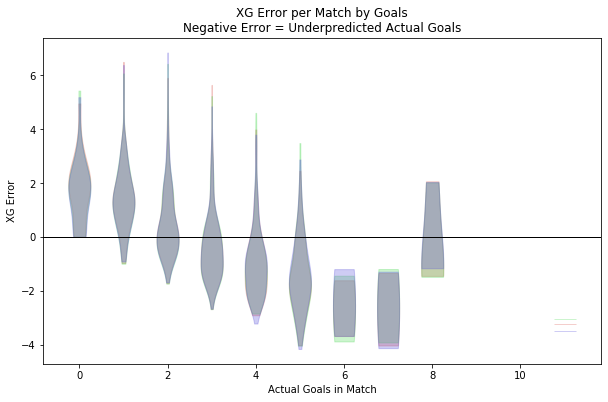

In [26]:
plot = blank_plot()
for model_id, color in zip(model_ids, pal):
    plot = plot_errors_by_goals(models[model_id], d_test, plot, {"color": color})
plot[1].get_legend().remove()
plot[0]